In [1]:
# Dependencies and models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import cleaned data 

df = pd.read_csv('cleaned_data.csv')
pd.set_option('display.max_columns', None)
df.head(2)

,title,rated,released,runtime,director,writer,actors,plot,language,country,awards,metascore,imdbrating,imdbvotes,dvd,boxoffice,response,genre,star,budget,gross,year,internet_movie_database_rating,rotten_tomato_rating,metacritic_rating
0,Inception,PG-13,2010-07-16,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French","United Kingdom, United States",Won 4 Oscars. 157 wins & 220 nominations total,74.0,8.8,2223702,07 Dec 2010,292576195.0,True,Action,Leonardo DiCaprio,160000000.0,836836967.0,2010,8.8,87.0,74.0
1,Iron Man 2,PG-13,2010-05-07,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",United States,Nominated for 1 Oscar. 7 wins & 44 nominations...,57.0,7.0,771885,17 Aug 2010,312433331.0,True,Action,Robert Downey Jr.,200000000.0,623933331.0,2010,7.0,72.0,57.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   title                           1774 non-null   object 
 1   rated                           1753 non-null   object 
 2   released                        1774 non-null   object 
 3   runtime                         1774 non-null   int64  
 4   director                        1766 non-null   object 
 5   writer                          1771 non-null   object 
 6   actors                          1774 non-null   object 
 7   plot                            1774 non-null   object 
 8   language                        1771 non-null   object 
 9   country                         1773 non-null   object 
 10  awards                          1654 non-null   object 
 11  metascore                       1774 non-null   float64
 12  imdbrating                      17

In [4]:
# Replacing nulls with 'NA' and 0

df["rated"].fillna("NA", inplace = True)
df["director"].fillna("NA", inplace = True)
df["writer"].fillna("NA", inplace = True)
df["language"].fillna("NA", inplace = True)
df["country"].fillna("NA", inplace = True)
df["awards"].fillna("NA", inplace = True)
df["metascore"].fillna(0, inplace = True)
df["dvd"].fillna("NA", inplace = True)
df["boxoffice"].fillna(0, inplace = True)
df["budget"].fillna(0, inplace = True)
df["gross"].fillna(0, inplace = True)

# Check for any nulls 

df.isnull().sum()

title                             0
rated                             0
released                          0
runtime                           0
director                          0
writer                            0
actors                            0
plot                              0
language                          0
country                           0
awards                            0
metascore                         0
imdbrating                        0
imdbvotes                         0
dvd                               0
boxoffice                         0
response                          0
genre                             0
star                              0
budget                            0
gross                             0
year                              0
internet_movie_database_rating    0
rotten_tomato_rating              0
metacritic_rating                 0
dtype: int64

## Data Preprocessing for model

### Adding label column based on IMDB Rating (rating(<5): label 0,rating(>=5 and <8):label1,rating(>8):label2

In [5]:
df['label']=''
for index, row in df.iterrows():
    if (row['imdbrating']<5):
        df.loc[index, 'label']=0
    elif (row['imdbrating']>=5)&(row['imdbrating']<8):
        df.loc[index, 'label']=1
    elif (row['imdbrating']>=8):
        df.loc[index, 'label']=2

In [6]:
df['label'].value_counts()

1    1622
0      78
2      74
Name: label, dtype: int64

In [7]:
df['label'].dtype

dtype('O')

In [8]:
df['label']=pd.to_numeric(df['label'])
df['label'].fillna(0,inplace=True)
df['label']=df['label'].astype('int')

In [9]:
df['label']

0       2
1       1
2       2
3       1
4       1
       ..
1769    1
1770    0
1771    0
1772    0
1773    1
Name: label, Length: 1774, dtype: int64

### Dropping Columns not required for the model

In [10]:
df=df.drop(['title','released','plot','awards','metascore','imdbrating' ,'imdbvotes','dvd',
           'boxoffice','response','gross', 'year','internet_movie_database_rating',
           'rotten_tomato_rating','metacritic_rating'],axis=1)                                                 
df.columns

Index(['rated', 'runtime', 'director', 'writer', 'actors', 'language',
       'country', 'genre', 'star', 'budget', 'label'],
      dtype='object')

### Create Function for one hot encoding of writer, actors,language, country columns

In [11]:
def one_hot_encode(column,new_col_names):
    
    for index, row in df.iterrows():
        item_names=str(row[column]).split(',')
        for y in item_names:
            y=y.strip()
            if y in new_col_names:
                df.loc[index, y]=1
        

### One Hot Endcoding: Country

In [12]:
from collections import Counter
# Find most common country names
countries=df['country'].to_list()

country_list=[]

for x in countries:
    
        country_array = str(x).split(',')
        for y in country_array:
            y=y.strip()
            country_list.append(y)
most_common=Counter(country_list).most_common(10)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('country',new_col_names)

### One Hot Encoding : Language

In [13]:
languages=df['language'].to_list()

language_list=[]

for x in languages:
    
        language_array = str(x).split(',')
        for y in language_array:
            y=y.strip()
            language_list.append(y)
most_common=Counter(language_list).most_common(15)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('language',new_col_names)


### One Hot Encoding :writer

In [14]:
writers=df['writer'].to_list()

writer_list=[]

for x in writers:
    
        writer_array = str(x).split(',')
        for y in writer_array:
            y=y.strip()
            writer_list.append(y)
most_common=Counter(writer_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('writer',new_col_names)

### One Hot Encoding :actors

In [15]:
actors=df['actors'].to_list()

actor_list=[]

for x in actors:
    
        actor_array = str(x).split(',')
        for y in actor_array:
            y=y.strip()
            actor_list.append(y)
most_common=Counter(actor_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('actors',new_col_names)



In [16]:
df=df.drop(['country','language','writer','actors'],axis=1)

In [17]:
df.columns

Index(['rated', 'runtime', 'director', 'genre', 'star', 'budget', 'label',
       'United States', 'United Kingdom', 'France',
       ...
       'Jessica Chastain', 'Chris Evans', 'Mark Ruffalo', 'Nicolas Cage',
       'Chloë Grace Moretz', 'Johnny Depp', 'Kristen Stewart', 'Amy Adams',
       'Robert De Niro', 'Chris Pine'],
      dtype='object', length=132)

In [18]:
df.shape

(1774, 132)

In [19]:
df.head(5)

,rated,runtime,director,genre,star,budget,label,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,English,Spanish,French,German,Russian,Italian,Japanese,Mandarin,Hindi,Arabic,Ukrainian,Korean,Hebrew,Swedish,Latin,Luc Besson,Nicholas Stoller,Jane Goldman,Allan Loeb,Stan Lee,Sean Anders,Brian Helgeland,Cinco Paul,Ken Daurio,Phil Hay,Sylvester Stallone,Nicholas Sparks,Woody Allen,John Morris,Matthew Vaughn,Ethan Reiff,Dan Fogelman,Matt Manfredi,Peter Straughan,Mark Bomback,Darren Lemke,Jennifer Lee,Jez Butterworth,Jonathan Aibel,Billy Ray,Evan Daugherty,Christopher Markus,Stephen McFeely,Steven Knight,Jeff Pinkner,Gary Dauberman,Christopher Nolan,Michael Bacall,Edgar Wright,Adam Sandler,Leigh Whannell,Joel Coen,Ethan Coen,Christopher McQuarrie,Simon Beaufoy,Adam McKay,Hans Christian Andersen,Chris Buck,Peter Morgan,Noah Baumbach,John-Henry Butterworth,Guillermo del Toro,Chris Morgan,Glenn Berger,Josh Appelbaum,Mark Wahlberg,Michael Fassbender,Liam Neeson,Dwayne Johnson,Steve Carell,Jennifer Lawrence,Owen Wilson,Scarlett Johansson,Matthew McConaughey,Gerard Butler,Matt Damon,Jonah Hill,Bradley Cooper,Keira Knightley,Ryan Reynolds,Emily Blunt,Channing Tatum,Chris Hemsworth,Tom Hardy,Robert Downey Jr.,Cate Blanchett,Emma Stone,Nicole Kidman,Seth Rogen,Anna Kendrick,Kevin Hart,Jesse Eisenberg,Helen Mirren,Robert Pattinson,Joel Edgerton,Rachel McAdams,Rachel Weisz,Naomi Watts,Jake Gyllenhaal,Hugh Jackman,Russell Crowe,Michelle Williams,James Franco,Anne Hathaway,Zac Efron,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,PG-13,148,Christopher Nolan,Action,Leonardo DiCaprio,160000000.0,2,1,1,,,,,,,,,1,,1,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,PG-13,124,Jon Favreau,Action,Robert Downey Jr.,200000000.0,1,1,,,,,,,,,,1,,1,,1,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,R,138,Martin Scorsese,Mystery,Leonardo DiCaprio,80000000.0,2,1,,,,,,,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,
3,PG-13,112,Edgar Wright,Action,Michael Cera,60000000.0,1,1,1,,1,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,PG-13,102,Dennis Dugan,Comedy,Adam Sandler,80000000.0,1,1,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [20]:
df.fillna(0,inplace=True)


In [21]:
df.isnull().sum()

rated              0
runtime            0
director           0
genre              0
star               0
                  ..
Johnny Depp        0
Kristen Stewart    0
Amy Adams          0
Robert De Niro     0
Chris Pine         0
Length: 132, dtype: int64

### Reducing type of rated by merging two or more types in one

In [22]:
df.loc[df['rated']=='TV-MA', 'rated'] = 'R'
df.loc[df['rated']=='NC-17', 'rated'] = 'R'
df.loc[df['rated']=='TV-14', 'rated'] = 'PG-13'
df.loc[df['rated']=='TV-PG', 'rated'] = 'PG'
df.loc[df['rated']=='Unrated', 'rated'] = 'NA'
df.loc[df['rated']=='Not Rated', 'rated'] = 'NA'

In [23]:
stars = df.star.value_counts()
stars_filter = stars[stars< 2]


In [24]:
stars_replace = stars[stars<5].index.to_list()
for star in stars_replace:
  df['star'] =  df['star'].replace(star,'other')

df['star'].value_counts() 

other                  1197
Mark Wahlberg            13
Steve Carell             12
Matt Damon               12
Matthew McConaughey      12
                       ... 
Saoirse Ronan             5
Mia Wasikowska            5
Sam Worthington           5
Daniel Craig              5
Charlize Theron           5
Name: star, Length: 82, dtype: int64

In [25]:
df.isnull().sum()

rated              0
runtime            0
director           0
genre              0
star               0
                  ..
Johnny Depp        0
Kristen Stewart    0
Amy Adams          0
Robert De Niro     0
Chris Pine         0
Length: 132, dtype: int64

In [59]:
df.dtypes

rated              object
runtime             int64
director           object
genre              object
star               object
                    ...  
Johnny Depp        object
Kristen Stewart    object
Amy Adams          object
Robert De Niro     object
Chris Pine         object
Length: 132, dtype: object

In [26]:
# Save as final csv file for model
df.to_csv('fin_data.csv')

### Splitting Feature and Target Columns

In [28]:
df2=df.drop('label',axis=1)
y=df['label']

In [29]:
X=pd.get_dummies(df2)
X.shape

(1774, 1468)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1)

In [31]:
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Trying RandomForest Classifier

In [32]:
model=RandomForestClassifier (random_state=1,n_estimators=500)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [33]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [34]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:1.0,testing_score:0.9118198874296435


In [35]:

pred = model.predict(X_test[:1])
pred

array([1])

In [36]:
X_test[:1].count()

runtime             1
budget              1
rated_G             1
rated_NA            1
rated_PG            1
                   ..
Amy Adams_          1
Robert De Niro_1    1
Robert De Niro_     1
Chris Pine_1        1
Chris Pine_         1
Length: 1468, dtype: int64

In [37]:
y_test[:1]

1693    1
Name: label, dtype: int64

### Trying SVC

In [38]:
from sklearn.svm import SVC

In [39]:
model=SVC()
model.fit(X_train_scaled,y_train)

SVC()

In [40]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [41]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9307010475423045,testing_score:0.9136960600375235


In [42]:
y_test[:1]

1693    1
Name: label, dtype: int64

### Trying K-Nearestneighbors

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
train_scores=[]
test_scores=[]

In [45]:
for k in range (1,20,2):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled,y_train)
    train_score=knn.score(X_train_scaled,y_train)
    test_score=knn.score(X_test_scaled,y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

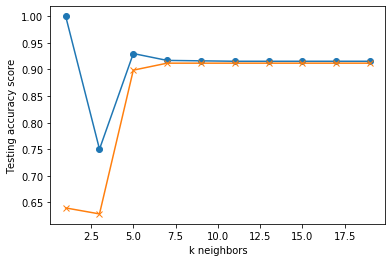

In [46]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [47]:
knn=KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled,y_train)


KNeighborsClassifier(n_neighbors=8)

In [48]:
training_score = knn.score(X_train_scaled, y_train)
testing_score = knn.score(X_test_scaled, y_test)

In [49]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9161966156325544,testing_score:0.9118198874296435


### Trying other ensemble methods

In [50]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier

### ExtraTreesClassifier

In [51]:
model=ExtraTreesClassifier()
model.fit(X_train_scaled,y_train)

ExtraTreesClassifier()

In [52]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [53]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:1.0,testing_score:0.9024390243902439


### AdaBoostClassifier

In [54]:
model=AdaBoostClassifier()
model.fit(X_train_scaled,y_train)

AdaBoostClassifier()

In [55]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [56]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.8356164383561644,testing_score:0.849906191369606
